# Geometric optics
<pre>
PH3080 (Computational Physics)
Michael Mazilu and Aly Gillies, University of St Andrews
ph3080@st-andrews.ac.uk 
Version: 2022; (CC BY-NC 2.0) 
</pre>

In [1]:
%matplotlib inline
import numpy as np

from scipy.optimize import minimize
from scipy.linalg import eig

import matplotlib.pyplot as plt

## Physics background

<img src="../../ph3080/img/osys.png" width =750/>

In this study we will model the propagation of rays through simple optical systems consisting of lenses and curved mirrors.
To do this, we use the small angle approximation, i.e. the rays propagate in a *paraxial regime* (close to the optic-axis), where the following relationship is valid:

$$\begin{pmatrix}x_2\\ x'_2\end{pmatrix}=\begin{pmatrix}A&B\\C&D\end{pmatrix} \begin{pmatrix}x_1\\ x'_1\end{pmatrix} \label{abcd}$$

In this, $x_1$ and $x'_1$ are the height and gradient of the incident ray with respect to the optic-axis at position $z_1$. Similarly, $x_2$ and $x'_2$ are the height and gradient of the transmitted ray at position $z_2$.  The matrix elements $A$, $B$, $C$ and $D$  describe an optical system consisting of one or more optical components. 
In optics, these matrices are called **ABCD** matrices. 
Of particular interest to us are the following fundamental optical components:

| Free-space distance $d$ | Thin lens | Curved mirror | Object/Imaging plane|
| --- | --- | --- | --- |
| $$\begin{pmatrix}1&d\\0&1\end{pmatrix}$$ | $$\begin{pmatrix}1&0\\\displaystyle -\frac{1}{f}&1\end{pmatrix}$$ | $$\begin{pmatrix}1&0\\\displaystyle -\frac{2}{R_m}&1\end{pmatrix}$$ | $$\begin{pmatrix}1&0\\0&1\end{pmatrix}$$ |

where $f$ is the focal length of the thin lens, with $f>0$ for a convex lens,
and $R_m$ is the radius of curvature of the mirror with $R_m>0$ for a concave mirror.

In our discussions we will call the vector  ($x$, $x'$) the *ray-state* vector.

Propagation through multiple optical components allows for the modelling of microscopes, telescopes and laser cavities, and can be achieved via matrix multiplication.

## Programming techniques
### Linear algebra
Initially, we define a function that takes distance, $d$, as an argument and generates the ABCD matrix corresponding to a free-space propagation distance. In this case study, we will assume all distanced are in the same units, in this case  millimetres, unless otherwise stated.

In [2]:
def dist(d):
    ABCD = np.identity(2) # start with the identity matrix then modify
    ABCD[0,1]= d          # change value in first row, second column
    return ABCD
print(dist(5))

[[1. 5.]
 [0. 1.]]


### Define additional ABCD matrices
Define functions for the other two fundamental optical components, naming them `lens` and `mirror`. Define a function called `plane` that returns the identity matrix for use as a placeholder for the object and imaging planes.

In [3]:
def lens(f):
    ABCD = np.identity(2)
    ABCD[1,0]= -1/f
    return ABCD

def mirror(R):
    ABCD = np.identity(2)
    ABCD[1,0]= -2/R
    return ABCD

def plane():
    ABCD = np.identity(2)
    return ABCD

print("lens:\n",lens(5), "\nmirror:\n", mirror(5), "\nplane:\n", plane())

lens:
 [[ 1.   0. ]
 [-0.2  1. ]] 
mirror:
 [[ 1.   0. ]
 [-0.4  1. ]] 
plane:
 [[1. 0.]
 [0. 1.]]


### Verification through a simple system
Consider a ray, defined by $z_1=0$, $x_1=40$ and $x'_1=-0.2$, propagating through a lens positioned at $z=300$ with focal length $f=180$. 

Using the matrix multiplication method, verify that at position $z=450$ the ray's height and gradient are $-33.3333$ and $-0.0888889$ respectively. Remember that the ray has to go through free space up to the lens ($0$ to $300$), then through the lens, then through free space to the requested position ($300$ to $450$).

In [4]:
ray0 = np.array([40, -0.2]) # numpy natively treats a 1D array as a column vector, can also use np.array([[x], [x']])
ray1 = dist(300)@ray0
ray2 = lens(180)@ray1
ray3 = dist(150)@ray2

print(ray3)

[-33.33333333  -0.08888889]


### Draw the optics
Use `matplotlib.pyplot` to create a plot showing the lens, the optic-axis, and the ray before and after the lens, up to the point of observation. Use `plt.plot` and a dashed line for the lens (diameter 50), a solid line for the ray segments and an `axhline` for the optic-axis.

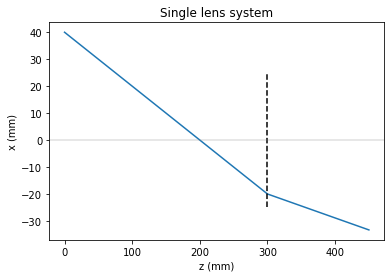

In [5]:
fig = plt.figure()

plt.title("Single lens system")
plt.xlabel("z (mm)")
plt.ylabel("x (mm)")
plt.plot([0, 300, 450], [ray0[0], ray1[0], ray3[0]]) # plot the ray 
plt.plot([300,300],[-25,25], c="k", linestyle="--")  # plot the lens
plt.axhline(0, c="lightgray")                 # plot the optic-axis

fig.show()

### Add another lens
Add a second lens, positioned at $z=400$ with focal length $f=100$, and recalculate the final height and gradient of our original ray at position $z=450$.

In [6]:
ray0 = np.array([40, -0.2])
ray1 = dist(300)@ray0
ray2 = lens(180)@ray1
ray3 = dist(100)@ray2
ray4 = lens(100)@ray3
ray5 = dist(50)@ray4

print(ray5)

[-18.88888889   0.2       ]


### Compare with combined matrix
Verify that you get the same final height and gradient when using a combined ABCD matrix for the whole two-lens system. Make sure that you multiply the ABCD matrices in the correct order and take into account the free-space propagation between elements. 

In [7]:
system = dist(50)@lens(100)@dist(100)@lens(180)@dist(300)
ray0 = np.array([40, -0.2])
print(system@ray0)

[-18.88888889   0.2       ]


### Predefined functions
To continue with the case study we will use a few purpose-built functions. These are defined in the cell below.

As inputs, these functions use single rays and single optical elements defined as dictionaries. Multiple rays and multiple optical elements are defined as lists of such dictionaries.

In [8]:
def new_ray(x, dx, z=0, color=(1,0,0)): # define a new ray
    return {
        "state": np.array([x, dx]), # height and gradient of ray
        "z1":z, "z2":np.inf,        # start position and end position of ray (default end is infinity)
        "color":color               # colour that will be used to plot ray
    }

def new_opt(trans, z, diam=0): # define a new optical element with ABCD matrix, position and aperture size
    return {"trans":trans, "z":z, "diam":diam} 

def prop_one(rays, opt):
    """
    Propagate a list of rays through a single optical element, 
    checking first that they actually intercept the optical element.
    
    rays (list): a list of rays
    opt (dictionary): an optical element
    
    returns (list): a list of rays
    """
    # extract the details of the optical element
    z = opt["z"]
    trans = opt["trans"]
    diam = opt["diam"]
    
    #define an empty list in which to store the propagated rays
    out_rays = []
    
    # propagate the rays
    for ray in rays:  # take each ray at a time from the list of rays
        # make a copy of the ray to prevent changing the input
        in_ray = ray.copy()
        # extract the ray's properties
        state = in_ray["state"]
        z1 = in_ray["z1"]
        z2 = in_ray["z2"]
        color = in_ray["color"]
        # check the ray is still active and begins before the optical element
        if z2 == np.inf and z1 <= z:
            # if the ray reaches the optical element then stop it there
            in_ray["z2"] = z
            
            # propagate the ray *to* the optical element
            state1 = dist(z-z1)@state
            # check if the ray gets through the aperture, if it does 
            # then calculate a new ray emitted from the optical emement
            if np.abs(state1[0]) < diam/2 :
                # calculate the effect of the optical element
                state2 = trans@state1
                # and create a new ray
                out_ray = new_ray(*state2, z, color)
                # and put it in our list of rays 
                out_rays.append(out_ray)
        
        # always put the incident ray in our list (with modified z2 if appropriate)
        out_rays.append(in_ray)
    return out_rays

def prop_rays(rays, optics):
    """
    propagate a list of rays through a list of optical elements
    
    rays (list): a list of rays
    opts (list): an optical element
    """
    for opt in optics: # take each optical element in turn
        rays = prop_one(rays, opt) # propogate all rays through chosen optic
    return rays

def combined_ABCD(optics):
    """
    Calculate the combined transformation ABCD matrix of a list of optical elements
    
    optics (list): a list of optical elements
    
    returns (np.array): the net transformation
    """
    
    trans = np.identity(2) # start with identity matrix
    z = optics[0]["z"]     # prepare distance to next (first) optical element
    
    for opt in optics:     # for each element in the optical configuration
        freesp_ABCD = dist(opt["z"]-z)
        trans = opt["trans"]@freesp_ABCD@trans # include transit to and through optic
        z = opt["z"]       # prepare distance to next optical element 
    return trans


def show_optics(rays, optics):
    """
    Visualise an optical setup and the rays propagated through it.
    
    rays (list): a list of rays
    optics (list): a list of optical elements
    
    return: None
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.set_title("Optical system")
    ax.set_xlabel("z (mm)")
    ax.set_ylabel("x (mm)")
    
    ax.axhline(0, c="lightgray", zorder=0, linestyle="dashed") # draw optic-axis
    
    for opt in optics:  # for each optic in turn
        z = opt["z"]
        diam = opt["diam"]
        if diam != 0:    
            ax.axvline(z, c="k", zorder=0)                                        # draw an infinite, vertical, black line at position of optic
            ax.plot([z,z], [diam/2, -diam/2], c="w", linestyle="-", zorder=0)     # draw a white line for the aperture
            ax.plot([z,z], [diam/2, -diam/2], c="k", linestyle="--", zorder=10)   # make the aperture dotted for visibility
                    
    z_max = ax.get_xlim()[1] # get maximum x from plot of optical elements
    z_max = z_max + z_max/10 # extend 10% beyond max x from plot to distance past last optic
    for ray in rays:
        state = ray["state"]
        z1 = ray["z1"]
        z2 = ray["z2"]
        color = ray["color"]
        
        if z2 == np.inf:
            z2 = z_max
            linestyle = "--"
        else:
            linestyle = "-"
            
        x1 = state[0]
        x2 = state[0] + state[1]*(z2-z1) # use gradient and separation to change height
             
        ax.plot([z1,z2], [x1, x2], c=color, zorder=5, linestyle=linestyle)

In [9]:
# a ray as a dictionary
print(new_ray(2, 0.01)) # ray with height 2mm, gradient 0.01

# an optical system as a list of dictionaries - a telescope
obj = new_opt(plane(), 0, 100)
lens1 = new_opt(lens(200), 200, 25)
lens2 = new_opt(lens(400), 800, 25)
end = new_opt(plane(), 1200)

tele = [obj, lens1, lens2, end]
print(tele)

{'state': array([2.  , 0.01]), 'z1': 0, 'z2': inf, 'color': (1, 0, 0)}
[{'trans': array([[1., 0.],
       [0., 1.]]), 'z': 0, 'diam': 100}, {'trans': array([[ 1.   ,  0.   ],
       [-0.005,  1.   ]]), 'z': 200, 'diam': 25}, {'trans': array([[ 1.    ,  0.    ],
       [-0.0025,  1.    ]]), 'z': 800, 'diam': 25}, {'trans': array([[1., 0.],
       [0., 1.]]), 'z': 1200, 'diam': 0}]


### Create a bundle of parallel rays
Create a list of parallel rays named `rays` with $x$ ranging from $-5$ to $5$ in steps of $1$, all with gradient $0.01$. This list corresponds to a bundle of upward-propagating parallel rays.

In [10]:
rays = []
for x in np.arange(-5,6,1):
    rays.append(new_ray(x, 0.01))

### Propagate rays through telescope
Use `prop_rays(rays,tele)` to calculate the propagation of the bundle of rays defined by the list `rays` through the telescope `tele`. Name the list of rays output from the function `p_rays`.

In [11]:
p_rays = prop_rays(rays, tele)

### Draw propagation through telescope
Use the `show_optics` function to display the propagated rays, `p_rays`, as they pass through the telescope.

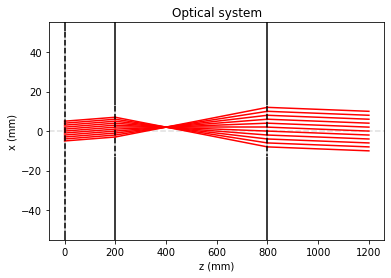

In [12]:
show_optics(p_rays, tele)

<a id="verifyABCD"></a>
### Verify combined ABCD matrix
Using matrix multiplication (@ in Python), calculate the ABCD matrix for the whole telescope. Check your output against that calculated using the `combined_ABCD` function.

In [13]:
tele_mat = plane()@dist(400)@lens(400)@dist(600)@lens(200)@dist(200)
print(tele_mat,"\n")
print(combined_ABCD(tele))

[[-2.   0. ]
 [ 0.  -0.5]] 

[[-2.   0. ]
 [ 0.  -0.5]]


### Imaging systems
The following code defines a point source with rays emerging at varying gradients.

In [14]:
rays = []
for dx in np.arange(-0.01, 0.01, 0.001):
    rays.append(new_ray(2,dx))

### Plot imaging in telescope
Display the propagation of the `rays` from the point source through the telescope defined by `tele`. Notice that all the rays are focused by the telescope to a single point. This telescope configuration is called a 4F arrangement, i.e. distance $f_1$ between the object and the first lens, distance $f_1 + f_2$ between the two lenses, and distance $f_2$ between the second lens and the imaging plane.

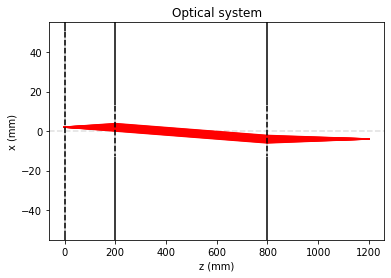

In [15]:
p_rays = prop_rays(rays, tele)
show_optics(p_rays, tele)

## Study
We want to study the properties of an optical system as a function of its constituent parts. We will look at imaging in an eye, discuss magnification factor, and study rays in periodic focusing systems.

### Model imaging of an eye
Model an eye as a lens, positioned at $z=400$ with a focal length of $17$, and a retina (imaging plane) at a distance of 17 behind the lens (positioned at $z=417$). Use $10$ as the iris diameter of the eye. Use the `show_optics` function to model the eye looking at a point-source object at $z=0$ and $x=10$ (set the aperture diameter as 100) with a ray bundle of gradient varying from $-0.05$ to $0.00$ in steps of $0.002$. Is the object in focus? You may wish to zoom in to examine the focal point more closely; use the "Zoom to rectangle" option (little square control) on the plot to zoom (assuming you are using `%matplotlib widget`).

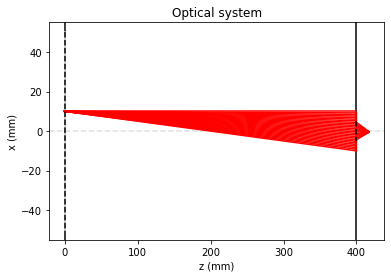

In [16]:
obj = new_opt(plane(), 0, 100)
lens0 = new_opt(lens(17), 400,10)
retina = new_opt(plane(), 417)
eye = [obj, lens0, retina]

rays = []
for dx in np.arange(-0.05, 0.002, 0.002):
    rays.append(new_ray(10,dx))
    
p_rays = prop_rays(rays, eye)
show_optics(p_rays, eye)

### Quantifying focus
Define a function called `focus_variance` that takes the focal length of the eye's lens, and the object-to-eye distance as arguments. The function should return the variance of the distribution of the rays striking the retina. Plot the focus variance as a function of eye focal-length for three different object distances or $400$, $1000$ and $2000$.

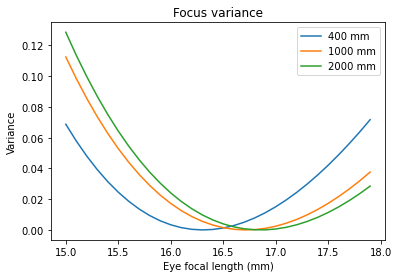

In [17]:
def focus_variance(eye_focal_length, obj_distance):
    lens_z = obj_distance
    retina_z = obj_distance + 17
    obj = new_opt(plane(), 0, 100)
    lens0 = new_opt(lens(eye_focal_length), lens_z, 10)
    retina = new_opt(plane(), retina_z)
    eye = [obj, lens0, retina]
    
    #define a dense bundle of rays to make a more statistically significant variance
    rays = [] 
    for dx in np.arange(-0.05, 0.05, 0.0005): 
        rays.append(new_ray(10,dx))

    p_rays = prop_rays(rays, eye)
    
    # extract the positions of rays strinking the retina
    retina_x = np.array([])
    for ray in p_rays:
        if ray["z2"] == retina_z:
            state = ray["state"]
            retina_x = np.append(retina_x, state[0] + state[1] * (ray["z2"] - ray["z1"]))
    return np.var(retina_x)

focal_length = np.arange(15,18,0.1) # the granularity determines precision of plot and looked-up minimum. 
focus_variance_400 = np.array([])
focus_variance_1000 = np.array([])
focus_variance_2000 = np.array([])
for foclen in focal_length:
    focus_variance_400=np.append(focus_variance_400,focus_variance(foclen, 400))
    focus_variance_1000=np.append(focus_variance_1000,focus_variance(foclen, 1000))
    focus_variance_2000=np.append(focus_variance_2000,focus_variance(foclen, 2000))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Focus variance")
ax.set_xlabel("Eye focal length (mm)")
ax.set_ylabel("Variance")

ax.plot(focal_length, focus_variance_400, label=f"{400} mm")
ax.plot(focal_length, focus_variance_1000, label=f"{1000} mm")
ax.plot(focal_length, focus_variance_2000, label=f"{2000} mm")
ax.legend()

fig.show()

### Find best focus
Find the minimum variance for each of the three object positions ($400$, $1000$ and $2000$) and determine the eye focal length producing these best focii. Use the `show_optics` function to show the propagation of a point-source object at $z=0$ and $x=10$ (set aperture diameter as 100) with a ray bundle of gradient varying from $-0.05$ to $0.00$ in steps of $0.001$.

In [18]:
focal_length_400 =  minimize(focus_variance, 17, args=(400), tol=1E-10).x[0]
focal_length_1000 = minimize(focus_variance, 17, args=(1000), tol=1E-10).x[0]
focal_length_2000 = minimize(focus_variance, 17, args=(2000), tol=1E-10).x[0]

print(f"  400 mm focal length: {focal_length_400:0.4f}\n",\
      f"1000 mm focal length: {focal_length_1000:0.4f}\n", \
      f"2000 mm focal length: {focal_length_2000:0.4f}") #printed with 4 decimal places

  400 mm focal length: 16.3070
 1000 mm focal length: 16.7158
 2000 mm focal length: 16.8567


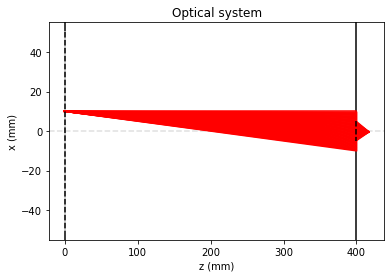

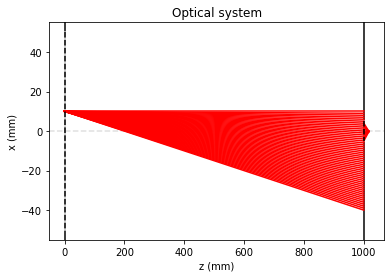

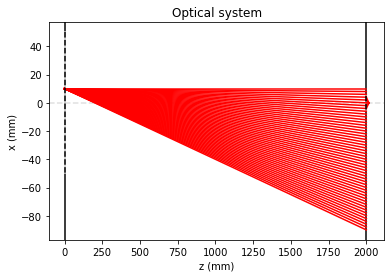

In [19]:
rays = []
for dx in np.arange(-0.05, 0.001, 0.001):
    rays.append(new_ray(10,dx))

obj = new_opt(plane(), 0, 100)
lens_400 = new_opt(lens(focal_length_400), 400,10)
retina_400 = new_opt(plane(), 417)
eye_400 = [obj, lens_400, retina_400]
p_rays_400 = prop_rays(rays, eye_400)
show_optics(p_rays_400, eye_400)

lens_1000 = new_opt(lens(focal_length_1000), 1000,10)
retina_1000 = new_opt(plane(), 1017)
eye_1000 = [obj, lens_1000, retina_1000]
p_rays_1000 = prop_rays(rays, eye_1000)
show_optics(p_rays_1000, eye_1000)

lens_2000 = new_opt(lens(focal_length_2000), 2000,10)
retina_2000 = new_opt(plane(), 2017)
eye_2000 = [obj, lens_2000, retina_2000]
p_rays_2000 = prop_rays(rays, eye_2000)
show_optics(p_rays_2000, eye_2000)

### Combined ABCD matrix of imaging systems
Calculate the overall ABCD matrices for each of the object positions ($400$, $1000$ and $2000$) when in best focus (minimum variance). You should have three ABCD matrices with $B \approx 0$. Indeed, any optical system where $B=0$ will be an imaging system.

In [20]:
ABCD_400 = combined_ABCD(eye_400)
ABCD_1000 = combined_ABCD(eye_1000)
ABCD_2000 = combined_ABCD(eye_2000)

np.set_printoptions(precision=3, floatmode='maxprec_equal', suppress=True) #print with set precision and suppress small values
print(ABCD_400,"\n")
print(ABCD_1000,"\n")
print(ABCD_2000)

[[ -0.043  -0.000]
 [ -0.061 -23.529]] 

[[ -0.017  -0.000]
 [ -0.060 -58.824]] 

[[  -0.009   -0.000]
 [  -0.059 -117.647]]


### Magnification factor
Taking any one of these ABCD matrices, determine the relationship between the height of the object and the image size on the retina. What is the magnification factor in relationship to the ABCD matrix?

In [21]:
state0 = np.array([1,0])
state400 = ABCD_400@state0
state1000 = ABCD_1000@state0
state2000 = ABCD_2000@state0

np.set_printoptions(precision=3, floatmode='maxprec_equal', suppress=True) # optional print with set precision and suppress small values
print("ABCD matrix: \n",ABCD_400)
print(f"Magnification: {state400[0]:.3f} \n") # magnification factor
print("ABCD matrix: \n",ABCD_1000)
print(f"Magnification: {state1000[0]:.3f} \n") # magnification factor
print("ABCD matrix: \n",ABCD_2000)
print(f"Magnification: {state2000[0]:.3f}") # magnification factor

ABCD matrix: 
 [[ -0.043  -0.000]
 [ -0.061 -23.529]]
Magnification: -0.043 

ABCD matrix: 
 [[ -0.017  -0.000]
 [ -0.060 -58.824]]
Magnification: -0.017 

ABCD matrix: 
 [[  -0.009   -0.000]
 [  -0.059 -117.647]]
Magnification: -0.009


### 4F system lateral magnification
Calculate the magnification for a $4F$ optical imaging telescope defined by two lenses with focal length $f_1$ and $f_2$ and check against that [calculated earlier](#verifyABCD).

Verify that the magnitude of this magnification factor is equal to $f_2/f_1$. Can you explain what the sign being negative means?

In [22]:
tele_mat = plane()@dist(400)@lens(400)@dist(600)@lens(200)@dist(200)
print("ABCD matrix: \n",tele_mat,"\n")
print("Magnification: ",tele_mat[0,0]) # magnification factor

print("The image in a 4F telescope is inverted, hence the negative sign.")

ABCD matrix: 
 [[-2.0  0.0]
 [ 0.0 -0.5]] 

Magnification:  -2.0
The image in a 4F telescope is inverted, hence the negative sign.


### Periodic optical system
Consider a periodically repeating optical system where each period consists of a thin lens of focal length $f$ and a distance $d$ of free-space propagation. Display the height of a ray starting with $(x_1 , x_1' ) = (1, 0)$ as it propagates through the first $100$ periods as a function of the period number. Do this for $f = 10$; $d = 1$ and for $f = 1$; $d = 10$. Comment on what you observe, and why this is the case.

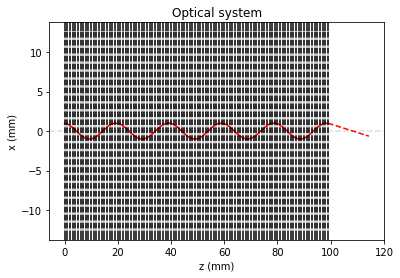

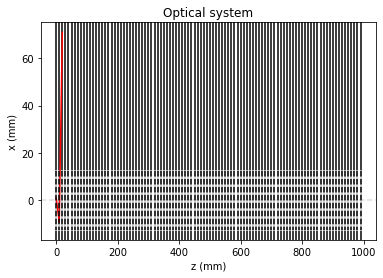

In [23]:
def periodic_system(f, d):
    """
    models the propagation of a ray trough a periodic system of lenses
    
    f (float): focal length of lenses
    d (float): lens seperation
    
    returns: None
    """
    optics = []

    for i in range(100):
        optics.append(new_opt(lens(f), d * i, 25))

    rays = [new_ray(1,0)]

    p_rays = prop_rays(rays, optics)
    show_optics(p_rays, optics)
    
periodic_system(10, 1)
periodic_system(1, 10)

### ABCD eigenvalue
Determine the eigenvalue of the single-period ABCD matrix and compare the absolute value of these in the two cases. What is the physical meaning of the eigenvalue with respect to the $x$-distance of the ray propagating through the system?

In [24]:
optics_10_1 = [new_opt(plane(), 0, 100), new_opt(lens(10), 1, 25)]
ABCD_10_1 = combined_ABCD(optics_10_1)
eigs_10_1 = np.abs(eig(ABCD_10_1)[0])

In [25]:
optics_1_10 = [new_opt(plane(), 0, 100), new_opt(lens(1), 10, 25)]
ABCD_1_10 = combined_ABCD(optics_1_10)
eigs_1_10 = np.abs(eig(ABCD_1_10)[0])

print(f"Eigenvalues for f=10, d=1: {eigs_10_1}")
print(f"Eigenvalues for f=1, d=10: {eigs_1_10}")
print('''
The eigenvalue is a multiplication coefficient of a ray-state eigenvector. Eigenvalues 
larger than one correspond to rays which move away from the optic-axis, while eigenvalues 
smaller than one correspond to rays which move towards the optic-axis. When propagated
through multiple periods then this corresponds to divergent or convergent rays, respectively.
Eigenvalues with an absolute value equal to one give stable rays through the system.
''')

Eigenvalues for f=10, d=1: [1. 1.]
Eigenvalues for f=1, d=10: [0.127 7.873]

The eigenvalue is a multiplication coefficient of a ray-state eigenvector. Eigenvalues 
larger than one correspond to rays which move away from the optic-axis, while eigenvalues 
smaller than one correspond to rays which move towards the optic-axis. When propagated
through multiple periods then this corresponds to divergent or convergent rays, respectively.
Eigenvalues with an absolute value equal to one give stable rays through the system.



### Stability region plot
Use the matplotlib `contourf` function to display the region of stability for our periodically repeating optical system with $d$ varying between $0$ and $10$ and $f$ between $-10$ and $10$. This is called a “lens&nbsp;equivalent&nbsp;waveguide”.

Expect this to take approx $10-15s$ to compute.

CPU times: user 11 s, sys: 29.3 ms, total: 11 s
Wall time: 11 s


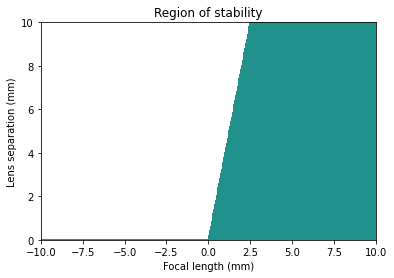

In [26]:
%%time

f_range = np.arange(-10.0, 10.05, 0.05)
d_range = np.arange(0.0, 10.05, 0.05)
stable = np.array([1,1])

X, Y = np.meshgrid(f_range, d_range)

def calculate_stability(f, d):
    ABCD = lens(f)@dist(d)
    eigs =  np.abs(eig(ABCD)[0])
    if max(eigs)<1.01:
        return 1
    return 0

stability=np.zeros(X.shape)
for i0 in range(X.shape[0]):
    for i1 in range(X.shape[1]):
        stability[i0,i1]=calculate_stability(X[i0,i1], Y[i0,i1])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("Region of stability")
ax.set_xlabel("Focal length (mm)")
ax.set_ylabel("Lens separation (mm)")

ax.contourf(X, Y, stability, [0.5,1.5])

fig.show()

### Laser cavity stability
Consider an optical cavity consisting of two spherical curved mirrors with radii $R_1$ and $R_2$ separated by the distance $L$. A round trip in the cavity corresponds to one period. Considering one full period of the cavity, plot the region of stability for $L = 1$ in the parameter space $R_1$ and $R_2$ varying each between $-4$ and $4$.

CPU times: user 4.59 s, sys: 17.4 ms, total: 4.61 s
Wall time: 4.6 s


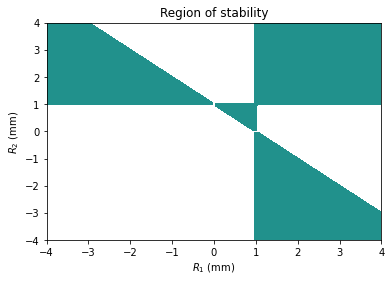

In [27]:
%%time
r_range = np.arange(-4.0, 4.05, 0.05)
L= 1

X, Y = np.meshgrid(r_range, r_range)

def calculate_stability(r1, r2):
    ABCD = mirror(r1)@dist(L)@mirror(r2)@dist(L)
    eigs =  np.abs(eig(ABCD)[0])
    if max(eigs)<1.01:
        return 1
    return 0

stability=np.zeros(X.shape)
for i0 in range(X.shape[0]):
    for i1 in range(X.shape[1]):
        stability[i0,i1]=calculate_stability(X[i0,i1], Y[i0,i1])
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Region of stability")
ax.set_xlabel("$R_1$ (mm)")
ax.set_ylabel("$R_2$ (mm)")

ax.contourf(X, Y, stability, [0.5,1.5])

fig.show()

## Advanced problem

The stability region is usually represented as a function of parameters $g_1$ and $g_2$, where $g_1 = 1 − L/R_1$ and $g_2 = 1 − L/R_2$. Considering the case where $L = 1$, write $R_1$ and $R_2$ as a function of $g_1$ and $g_2$, and re-plot the region of stability with $g_1$ and $g_2$ varying between $-4$ and $4$. Check your graph against https://en.wikipedia.org/wiki/Optical_cavity#Stability.

CPU times: user 23.2 s, sys: 44.7 ms, total: 23.3 s
Wall time: 23.3 s


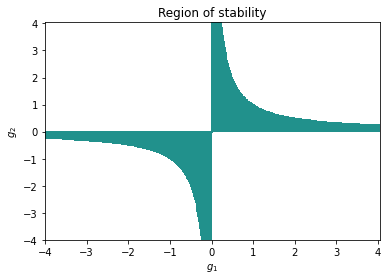

In [28]:
%%time

g_range = np.arange(-4.0, 4.05, 0.02)
n_g = len(r_range)
L = 1
stable = np.array([1,1])

X, Y = np.meshgrid(g_range, g_range)

def calculate_stability(g1, g2):
    r1 = L/(1-g1)
    r2 = L/(1-g2)
    ABCD = mirror(r1)@dist(L)@mirror(r2)@dist(L)
    eigs =  np.abs(eig(ABCD)[0])
    if max(eigs)<1.01:
        return 1
    return 0

stability=np.zeros(X.shape)
for i0 in range(X.shape[0]):
    for i1 in range(X.shape[1]):
        stability[i0,i1]=calculate_stability(X[i0,i1], Y[i0,i1])
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Region of stability")
ax.set_xlabel("$g_1$")
ax.set_ylabel("$g_2$")

ax.contourf(X, Y, stability, [0.5,1.5])

fig.show()

## Function glossary

- scipy.minimize
- plt.contourf
- np.meshgrid
- dictionaries